# **Assignment 2**, **dataset 3**


# Problem statement



### Loading the dataset

The PlantVillage dataset contains 54,304 images. The images span 14 crop species: Apple, Blueberry, Cherry, Corn, Grape, Orange, Peach, Bell Pepper, Potato, Raspberry, Soybean, Squash, Strawberry, Tomato. In containes images of 17 fungal diseases, 4 bacterial diseases, 2 mold (oomycete) diseases, 2 viral disease, and 1 disease caused by a mite. 12 crop species also have images of healthy leaves that are not visibly affected by a disease.

https://arxiv.org/pdf/1511.08060

https://github.com/gabrieldgf4/PlantVillage-Dataset

For this assignment, you will make a model that predicts whether a bell pepper leaf comes from a healthy or unhealthy plant (binary classification). The healthy bell pepper leaf images are in the `Pepper,_bell___healthy` folder, while unhealthy cherry leaf images are in `Pepper,_bell___Bacterial_spot`. You are allowed to use a pretrained model that you transfer to this problem, if you whish so. Keep in mind that the dataset is somewhat uneven between the classes. Make sure to apply a technique to mitigate for that.

In [2]:
# Download the dataset
!git clone https://github.com/gabrieldgf4/PlantVillage-Dataset.git

fatal: destination path 'PlantVillage-Dataset' already exists and is not an empty directory.


## **Exploratory Data Analysis**

The student will have to make a written analysis of the data being loaded (depending on the dataset that was assigned to them). They should apply methods of inspecting the data and make some exploratory data analysis

In [3]:
import os
DIR = "PlantVillage-Dataset"
#os.listdir('PlantVillage-Dataset') # We are only interested in the healthy and unhealthy bell pepper images
healthy_path = os.path.join(DIR, "Pepper,_bell___healthy")
unhealthy_path = os.path.join(DIR, "Pepper,_bell___Bacterial_spot")

First of all, we check our data distribution. We can see that we have more positive (healthy) than negative (unhealthy) examples; our dataset is thus imbalanced.

In [4]:
healthy_images = os.listdir(healthy_path)
unhealthy_images = os.listdir(unhealthy_path)
print("Healthy bell pepper images:", len(healthy_images))
print("Unhealthy bell pepper images:", len(unhealthy_images))
print("Total data set size:", len(healthy_images)+len(unhealthy_images))

Healthy bell pepper images: 1476
Unhealthy bell pepper images: 997
Total data set size: 2473


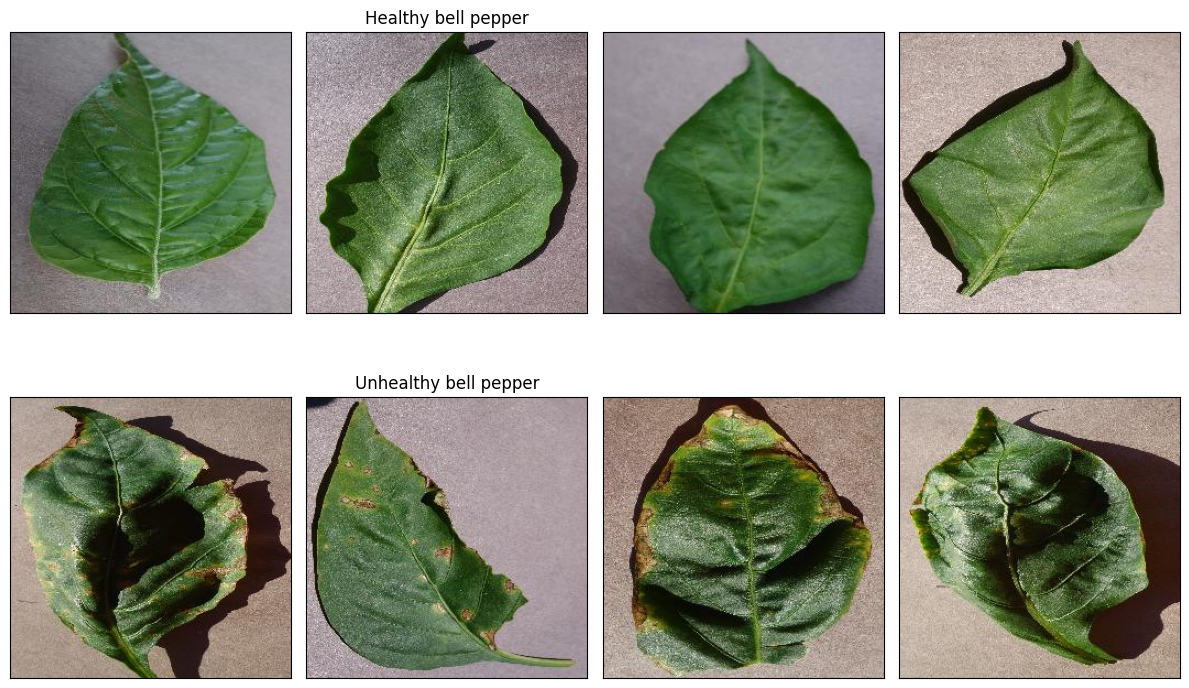

In [5]:
# inspect some examples for healthy and unhealthy bell peppers
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

healthy_images_sample = random.sample(healthy_images, 4)
unhealthy_images_sample = random.sample(unhealthy_images, 4)

plt.figure(figsize=(12, 8)) # code modified after exercise notebook 4 Computer Vision

for i, file_name in enumerate(healthy_images_sample):
  #print(file_name) # We have JPG images
  image = mpimg.imread(os.path.join(healthy_path,file_name))
  #print(image.shape) # (256, 256, 3) --> 256*256 pixels, colour images
  ax = plt.subplot(2, 4, i+1)
  plt.imshow(image)
  plt.axis('on')
  plt.xticks([])
  plt.yticks([])
  if i ==1:
    plt.title("Healthy bell pepper")


for i, file_name in enumerate(unhealthy_images_sample):
  image = mpimg.imread(os.path.join(unhealthy_path,file_name))
  ax = plt.subplot(2, 4, i+5)
  plt.imshow(image)
  plt.axis('on')
  plt.xticks([])
  plt.yticks([])
  if i ==1:
    plt.title("Unhealthy bell pepper")

plt.tight_layout()
plt.show()

## **Data Preprocessing**:

If applicable, the student will create new features from existing data to improve model performance and/or select the most relevant features for the model.

First, we have to create labels and then merge positive and negative images to one dataset which we subsequently split into train, val, and test set.

In [6]:
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
#from skimage import io
from PIL import Image

# code modified from: https://docs.pytorch.org/tutorials/beginner/data_loading_tutorial.html, assessed Aug 2, 2025 and https://medium.com/bivek-adhikari/creating-custom-datasets-and-dataloaders-with-pytorch-7e9d2f06b660.
# define a transform (here also data augmentation)
# resize depending on model, ResNet needs 224, 224 but we have (256, 256)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# create labels and merge images together
image_paths = []
labels = []

for fname in os.listdir(healthy_path):
    image_paths.append(os.path.join(healthy_path, fname))
    labels.append(1) # label 1 for healthy bell pepper

for fname in os.listdir(unhealthy_path):
    image_paths.append(os.path.join(unhealthy_path, fname))
    labels.append(0) # label 0 for unhealthy bell pepper


# define custom dataset

class BellPepperDataset(Dataset):
    """BellPepper Dataset."""

    def __init__(self, image_paths, labels, transform=None):
        """
        Arguments:
            image_paths (list): List of image paths.
            labels (list): List of labels.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.transform = transform
        self.image_paths = image_paths
        self.labels = labels

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert("RGB")
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

(tensor([[[0.8471, 0.8549, 0.8549,  ..., 0.7294, 0.7294, 0.7373],
         [0.8314, 0.8353, 0.8392,  ..., 0.7255, 0.7333, 0.7451],
         [0.8235, 0.8235, 0.8235,  ..., 0.7255, 0.7373, 0.7490],
         ...,
         [0.6078, 0.6196, 0.6314,  ..., 0.6275, 0.6314, 0.6549],
         [0.6471, 0.6588, 0.5765,  ..., 0.6431, 0.6196, 0.6431],
         [0.6118, 0.6588, 0.6235,  ..., 0.6235, 0.6078, 0.6471]],

        [[0.8235, 0.8314, 0.8314,  ..., 0.6784, 0.6784, 0.6863],
         [0.8078, 0.8118, 0.8157,  ..., 0.6745, 0.6824, 0.6941],
         [0.8000, 0.8000, 0.8000,  ..., 0.6745, 0.6863, 0.6980],
         ...,
         [0.5608, 0.5725, 0.5843,  ..., 0.5647, 0.5686, 0.5922],
         [0.6000, 0.6118, 0.5294,  ..., 0.5804, 0.5569, 0.5804],
         [0.5647, 0.6118, 0.5765,  ..., 0.5608, 0.5451, 0.5843]],

        [[0.8392, 0.8471, 0.8471,  ..., 0.7059, 0.7059, 0.7137],
         [0.8235, 0.8275, 0.8314,  ..., 0.7020, 0.7098, 0.7216],
         [0.8157, 0.8157, 0.8157,  ..., 0.7020, 0.7137, 0

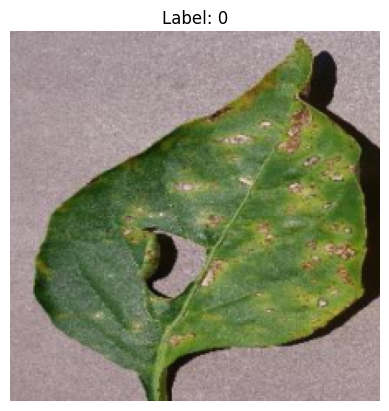

In [7]:
dataset = BellPepperDataset(image_paths, labels, transform)
print(dataset[0])
import torchvision.transforms.functional as TF

image, label = dataset[1500]
plt.imshow(TF.to_pil_image(image))
plt.title(f"Label: {label}")
plt.axis("off")
plt.show()

## **Data Transformation**

The student should prepare the data for the training. Augmenting, splitting, and otherwise transforming should be done here.

In [8]:
from torch.utils.data import random_split
import torch

dataset_len = len(dataset)
print(dataset_len)

# code modified from Computer_vision_exercise_solutions (Applied AI)

data_test_len  = int(dataset_len * 0.1)  # 10% test set
data_valid_len = int(dataset_len * 0.1)  # 10% valid set
data_train_len = dataset_len - data_test_len - data_valid_len

data_train, data_eval, data_test = torch.utils.data.random_split(dataset, [data_train_len, data_valid_len, data_test_len])

loaders = {
    'train' : torch.utils.data.DataLoader(data_train,
                                        batch_size=10,
                                        shuffle=True,
                                        num_workers=0,),

    'validation'  : torch.utils.data.DataLoader(data_eval,
                                        batch_size=10,
                                        shuffle=True,
                                        num_workers=0),
    'test'  : torch.utils.data.DataLoader(data_test,
                                        batch_size=3,
                                        shuffle=False,
                                        num_workers=0),
}

2473


In [ ]:
# There are several solutions for imbalanced dataset

## **Model Selection**


The student should implement a simple model as a baseline to compare more complex models. The student should try more complex modes and justify their rejection or acceptance.

As a baseline, I choose a simple CNN.
As a more complex model, I finetune a pre-trained ResNet.
torchvision.models

In [16]:
from torchvision import models
import torch.nn as nn
#model = models.resnet18(pretrained=True)

# build own classifier with ResNet backbone, code modified after
class CustomResNetModel(nn.Module):
    def __init__(self):
        super(CustomResNetModel, self).__init__()
        self.base_model = models.resnet18(pretrained=True) # ResNet18 backbone (pre-trained)

        for param in self.base_model.parameters(): # freeze all parameters, we only want to finetune the classification head
            param.requires_grad = False

        num_features = self.base_model.fc.in_features # modified after https://rumn.medium.com/part-1-ultimate-guide-to-fine-tuning-in-pytorch-pre-trained-model-and-its-configuration-8990194b71e
        self.base_model.fc = nn.Linear(num_features, 1)  # binary classification

    def forward(self, x):
        return self.base_model(x)

model = CustomResNetModel()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print(model)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


CustomResNetModel(
  (base_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=Tr

In [ ]:
# training loop

criterion = nn.BCEWithLogitsLoss() # code for training loop modified after https://docs.pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html and Computer_vision_exercise_solutions.ipynb
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(loaders['train'], 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        labels = labels.to(device).view(-1, 1).float()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 10 == 9:
          print(f'[{epoch + 1}, {i + 1:5d}] avg loss: {running_loss / 10:.4f}')
          running_loss = 0.0

print('Finished Training')


[1,    10] avg loss: 0.7115
[1,    20] avg loss: 0.6375
[1,    30] avg loss: 0.5387
[1,    40] avg loss: 0.5264
[1,    50] avg loss: 0.4486
[1,    60] avg loss: 0.4565
[1,    70] avg loss: 0.3718
[1,    80] avg loss: 0.3357
[1,    90] avg loss: 0.3375
[1,   100] avg loss: 0.3471
[1,   110] avg loss: 0.3593
[1,   120] avg loss: 0.3055
[1,   130] avg loss: 0.3141
[1,   140] avg loss: 0.2385
[1,   150] avg loss: 0.2230
[1,   160] avg loss: 0.1965
[1,   170] avg loss: 0.2124
[1,   180] avg loss: 0.2119
[1,   190] avg loss: 0.2890
[2,    10] avg loss: 0.2718
[2,    20] avg loss: 0.2132
[2,    30] avg loss: 0.1825


In [ ]:
import numpy as np
import time

def training_loop_simple(num_epochs, nn, loaders, loss_f, optimizer):
    loss_train = []
    loss_valid = []
    training_time = []
    min_valid_loss = np.inf

    if torch.cuda.is_available():
        nn.cuda()

    for epoch in range(num_epochs):
        time_epoch_start = time.time()

        # Train the model
        epoch_train_loss =
        nn.train()

        for i, (images, labels) in tqdm(enumerate(loaders['train']), total=len(loaders['train'])):
            if torch.cuda.is_available():
                images, labels = images.cuda(), labels.cuda()
            output = nn(images)
            loss = loss_f(output, labels)
            epoch_train_loss += loss.item()
            optimizer.zero_grad()

            loss.backward()
            optimizer.step()

        # Validatation phase
        epoch_val_loss = 0
        nn.eval()
        for i, (images_v, labels_v) in tqdm(enumerate(loaders['validation']), total=len(loaders['validation'])):
            if torch.cuda.is_available():
                images_v, labels_v = images_v.cuda(), labels_v.cuda()
            output = nn(images_v)
            loss_v = loss_f(output, labels_v)
            epoch_val_loss += loss_v.item()

        time_epoch_end = time.time()
        print(f'Epoch {epoch+1}')
        print(f'Training Loss: {epoch_train_loss / len(loaders["train"])}')
        print(f'Validation Loss: {epoch_val_loss / len(loaders["validation"])}')
        print('-------------------')

        loss_train.append(epoch_train_loss / len(loaders["train"]))
        loss_valid.append(epoch_val_loss / len(loaders["validation"]))
        training_time.append(time_epoch_end-time_epoch_start)

        if min_valid_loss > epoch_val_loss:
            print(f'Validation Loss Decreased({min_valid_loss}--->{epoch_val_loss}) \t Saving The Model')
            min_valid_loss = epoch_val_loss
            # Saving State Dict
            torch.save(nn.state_dict(), os.path.join(folder, 'saved_model.pth'))

training_loop_simple(
    num_epochs=10,
    nn=model,
    loaders=loaders,

)

## **Reporting the results**

The student should report the results. Identify which features are most influential in the model’s predictions, if applicable for the dataset and model used.

**Extra**: Any additional discussion and extra work relevant for solving the problem is welcome by the student and will contribute to a better grade.